# 线性回归from scratch
**数据流水线**、**模型**、**损失函数**和**小批量随机梯度下降优化器**
**自定义模型**，**自定义层**，**损失函数**

In [53]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。
我们使用线性模型参数 $\mathbf{w}=[2,-3,4]^T$、$b=4.2$和噪声项 $\epsilon$ 生成数据集及其标签：
$$
\mathbf{y} = \mathbf{Xw} + b + \epsilon
$$

## 生成数据集

In [37]:
# 构造数据集
def synthetic_data(w, b, num_examples):
    '''生成 y = Xw + b + 噪声'''
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b  
    # 生成的是行向量
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([1000, 2])


In [38]:
print('features:', features[0], '\nlabel：', labels[0])

features: tensor([0.0173, 0.9407]) 
label： tensor([1.0338])


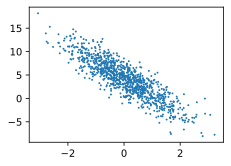

In [15]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

# 读取数据集
打乱数据集中的样本并以小批量方式获取数据
接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

In [40]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [32]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1397,  0.3595],
        [-0.2721,  0.4016],
        [-0.3213,  0.0908],
        [-0.0807,  0.5804],
        [ 0.2983,  1.5100],
        [ 1.4550,  0.0256],
        [-0.8320,  1.1086],
        [ 0.6546,  0.4218],
        [-1.5105, -1.9411],
        [ 1.2779, -0.2206]]) 
 tensor([[ 2.6964],
        [ 2.2980],
        [ 3.2394],
        [ 2.0676],
        [-0.3215],
        [ 7.0419],
        [-1.2048],
        [ 4.0628],
        [ 7.7847],
        [ 7.5127]])


# 初始化模型参数

In [33]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

在初始化参数之后，需要更新这些参数，直至这些参数足够拟合数据。

## 定义模型

将模型的输入和参数同模型的输出关联起来
计算输入特征$\mathbf{X}$和模型权重$w$的矩阵-向量乘法后加上偏执$b$

In [41]:
def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

## 定义损失函数

In [42]:
def squared_loss(y_hat, y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2/2

# 定义优化算法

从数据集中随机抽取一个小批量，根据 **参数计算损失的梯度**。 
优化算法的函数接收 **模型参数集合**、**学习率**、**批量大小**

In [43]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练

1. 每次迭代，读取一小批量训练样本，通过模型获得一组预测
2. 计算完损失后，开始反向传播，存储每个参数的梯度
3. 调用优化算法，更新模型参数

![](https://pic.imgdb.cn/item/61a3955d2ab3f51d91bc596b.jpg)

In [50]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为 l 形状是 (batch_size, 1) 而不是一个标量。 l 中的所有元素被加到一起
        # 兵钱一次计算关于 [w, b] 的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch1, loss 0.000052
epoch2, loss 0.000052
epoch3, loss 0.000052
epoch4, loss 0.000052
epoch5, loss 0.000052


In [52]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-1.3351e-05, -3.5644e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


## 小结
* 学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。
* 只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。